### Imports and Environment

In [77]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

import numpy as np

import collections
import gymnasium as gym
import numpy as np
import os

import tqdm

from matplotlib import pyplot as plt
from typing import Any, List, Sequence, Tuple

import pickle

import path_datatype
import sys

from env import tradingEng

# Define environment
file_path = os.path.abspath("../MarketGeneratingFunctions/1.6kRunDemo.pkl")
with open(file_path,"rb") as fp:
    paths = pickle.load(fp)
env = tradingEng(paths)

/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [124]:
import importlib
import env
importlib.reload(env) 
env = env.tradingEng(paths)

# DDPG

In [150]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True, skip_render_check=True)

AssertionError: The observation returned by the `reset()` method does not match the data type (cannot cast) of the given observation space Box([  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. -inf], [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 inf inf inf inf inf inf inf inf inf  1.  1.  1.  1.  1.  1.  1.  1.  1.
 inf], (37,), float32). Expected: float32, actual dtype: float64

### Making the Agent

In [125]:
n_actions = 18
action_noise = OrnsteinUhlenbeckActionNoise(mean = np.zeros(n_actions), sigma = 0.001*np.ones(n_actions), theta = 0.001)
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1, batch_size=25)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Training the Agent

In [126]:
Nruns = 10
model.learn(total_timesteps=252*10*Nruns, log_interval=2)
model.save("ddpg_fin")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -0.0116  |
| time/              |          |
|    episodes        | 2        |
|    fps             | 234      |
|    time_elapsed    | 10       |
|    total_timesteps | 2344     |
| train/             |          |
|    actor_loss      | -0.397   |
|    critic_loss     | 0.000196 |
|    learning_rate   | 0.001    |
|    n_updates       | 1172     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -0.0144  |
| time/              |          |
|    episodes        | 4        |
|    fps             | 162      |
|    time_elapsed    | 28       |
|    total_timesteps | 4688     |
| train/             |          |
|    actor_loss      | -0.573   |
|    critic_loss     | 0.000226 |
|    learning_rate   | 0.001    |
|    n_updates       | 3516     |
--------------

### Run a test

In [127]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=True)  # replace with actual agent
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated
env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1

In [51]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

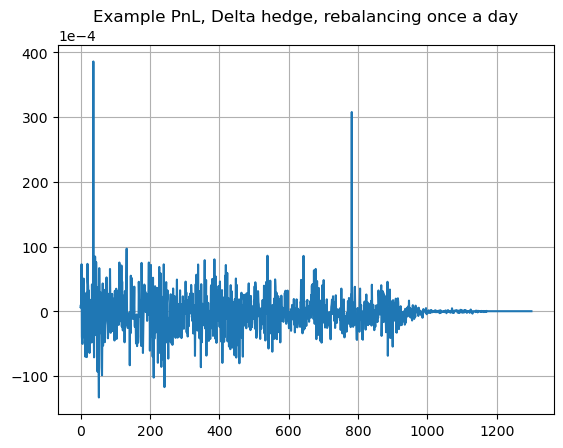

In [55]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[1])

In [53]:
np.percentile(pnl_tot[9], 5)

np.float64(-0.004446889275215954)

In [54]:
np.percentile(pnl_tot[1], 5)

np.float64(-0.004446889275215954)

# PPO

In [101]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1, batch_size=64*4*5, n_steps=2048, gamma=0.99, learning_rate=3e-4) 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/stable_baselines3/ppo/ppo.py:148: UserWarning: You have specified a mini-batch size of 1280, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2048`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 768
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2048 and n_envs=1)
  warnings.warn(


### Training the Agent

In [102]:
Nruns = 10*3
model.learn(total_timesteps=2520*10*Nruns, log_interval=2) # exploration_fraction=0.2
model.save("ppo_fin")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.3e+03     |
|    ep_rew_mean          | -0.0131     |
| time/                   |             |
|    fps                  | 2116        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010259988 |
|    clip_fraction        | 0.0763      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.5       |
|    explained_variance   | -42.366467  |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00383    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0221     |
|    std                  | 0.999       |
|    value_loss           | 0.133       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

### Run a test

In [103]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated
env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([ 1.469258  , -0.06069648,  0.07290989,  2.467265  ,  0.9945216 ,
        1.8310919 ,  0.9203104 ,  0.52005875,  1.4193056 ,  0.77630097,
       -0.43850294,  0.5359561 , -0.20770362, -0.52212626, -1.2396506 ,
        0.9936741 ,  0.26337028,  1.1866213 ], dtype=float32), array([ 0.6651152 , -0.8111297 , -0.12068921,  0.06974894,  0.6573615 ,
        1.4194542 , -0.70951164, -1.4847587 , -0.9851053 ,  0.27157152,
       -0.2819047 ,  1.4922781 ,  0.96073747,  0.70984244,  0.523037  ,
       -1.4363782 ,  0.3531171 , -0.1139257 ], dtype=float32), array([-0.19171678, -0.70593643, -0.30213258,  0.3551277 , -0.42510828,
       -1.7895405 ,  1.2269944 , -0.95613027,  0.45134687,  1.0994314 ,
        0.31133053,  2.5501952 ,  1.0150719 ,  2.4353871 ,  1.2544641 ,
       -0.12031065, -0.05434215,  1.2851137 ], dtype=float32), array([-1.0690029 ,  0.21681264, -0.54825145,  0.4032675 ,  0.10227448,
        1.5559251 ,  2.3248966 ,  2.5362108 ,  0.65025526,  0.905129

In [89]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

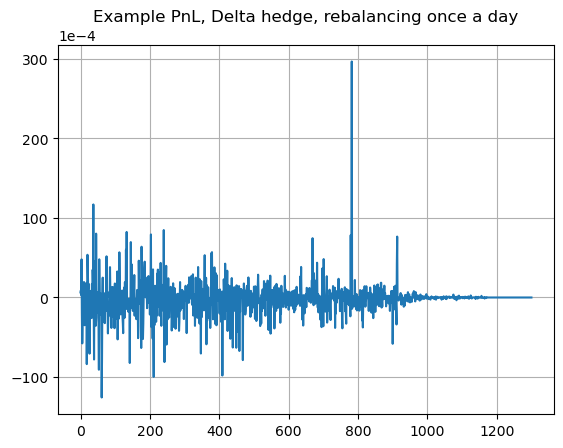

In [74]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[9])

In [94]:
np.mean([np.percentile(pnl[i], 5) for i in pnl_tot])

TypeError: list indices must be integers or slices, not list

def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])

plt.figure(2)
# Extract the 5% worst percentile values from each array
var_values_no_hedge = np.array([np.percentile(p,5) for p in pnl_without_hedge]) # is this really VaR?

var_values_no_hedge

TypeError: object of type 'numpy.float64' has no len()